In [ ]:
import torch
print(torch.cuda.is_available())

True


In [ ]:
!pip install transformers==4.51.3 arabert datasets scikit-learn

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, f1_score
from imblearn.over_sampling import RandomOverSampler
from datasets import Dataset
from arabert.preprocess import ArabertPreprocessor
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)

In [ ]:
df = pd.read_csv("/content/sample_data/CompanyReviews.csv")



X = df[['review_description']]
y = df['rating']

In [ ]:
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.over_sampling import SMOTE

arabert_model_name = "aubmindlab/bert-base-arabertv2"
arabert_prep = ArabertPreprocessor(model_name=arabert_model_name)

X_text = df['review_description'].astype(str).apply(arabert_prep.preprocess)
y = df['rating']


label_mapping = {-1: 0, 0: 1, 1: 2}
y = y.map(label_mapping)


X_train_text, X_test_text, y_train, y_test = train_test_split(X_text, y, test_size=0.3, random_state=42)

vectorizer = TfidfVectorizer(max_features=5000)
X_train_vect = vectorizer.fit_transform(X_train_text).toarray()



smote = SMOTE(random_state=42)
X_train_resampled_vect, y_train_resampled = smote.fit_resample(X_train_vect, y_train)

resampled_indices, _ = smote.fit_resample(
    np.arange(len(X_train_text)).reshape(-1, 1), y_train
)
X_train_resampled_text = X_train_text.iloc[resampled_indices.flatten()].reset_index(drop=True)

train_df = pd.DataFrame({'text': X_train_resampled_text, 'label': y_train_resampled})
test_df = pd.DataFrame({'text': X_test_text.reset_index(drop=True), 'label': y_test.reset_index(drop=True)})

[2025-05-09 18:12:15,423 - farasapy_logger - WARNING]: Be careful with large lines as they may break on interactive mode. You may switch to Standalone mode for such cases.


In [ ]:
from datasets import Dataset

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained("aubmindlab/bert-base-arabertv2")
def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)
tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/384 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/720k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.31M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/50607 [00:00<?, ? examples/s]

Map:   0%|          | 0/12014 [00:00<?, ? examples/s]

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    "aubmindlab/bert-base-arabertv2",
    num_labels=3
)



Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
from transformers import TrainingArguments, Trainer
from sklearn.metrics import accuracy_score, f1_score
import os
os.environ["WANDB_DISABLED"] = "true"



training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True
)


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    preds = predictions.argmax(-1)
    return {
        "accuracy": accuracy_score(labels, preds),
        "f1": f1_score(labels, preds, average="weighted")
    }

                                                                                                             # تجهيز المدرب
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_test,
    compute_metrics=compute_metrics
)

                                                                                                                  # بدء التدريب
trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


TrainOutput(global_step=18978, training_loss=0.8821445030512304, metrics={'train_runtime': 14953.2301, 'train_samples_per_second': 10.153, 'train_steps_per_second': 1.269, 'total_flos': 3.994614219288269e+16, 'train_loss': 0.8821445030512304, 'epoch': 3.0})


Classification Report:
              precision    recall  f1-score   support

 Hate Speech       0.85      0.83      0.84      4336
     Neutral       0.18      0.38      0.24       626
    Not Hate       0.92      0.84      0.88      7052

    accuracy                           0.81     12014
   macro avg       0.65      0.68      0.65     12014
weighted avg       0.86      0.81      0.83     12014



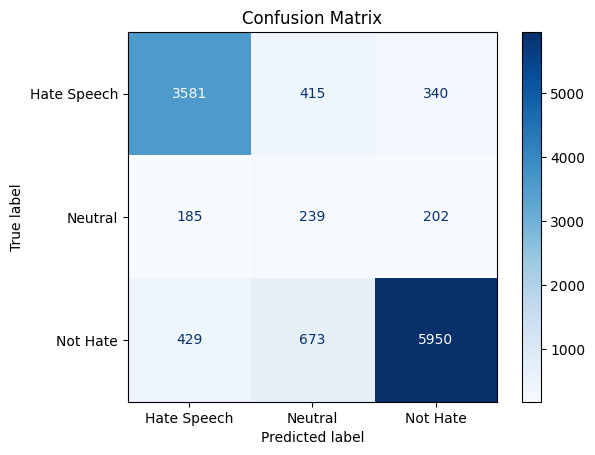

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# إجراء التنبؤ على بيانات الاختبار
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)

# تقرير التصنيف
print("\nClassification Report:")
print(classification_report(test_df['label'], preds, target_names=["Hate Speech", "Neutral", "Not Hate"]))

# رسم مصفوفة الالتباس
cm = confusion_matrix(test_df['label'], preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Hate Speech", "Neutral", "Not Hate"])
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score, f1_score
import numpy as np

# Predict on the test set
predictions = trainer.predict(tokenized_test)
preds = np.argmax(predictions.predictions, axis=1)

# Calculate final metrics
final_accuracy = accuracy_score(test_df['label'], preds)
final_f1 = f1_score(test_df['label'], preds, average="weighted")

# Print results
print(f"\n Final Accuracy: {final_accuracy:.4f}")
print(f" Final Weighted F1 Score: {final_f1:.4f}")




 Final Accuracy: 0.8132
 Final Weighted F1 Score: 0.8315
